### Step 0 - Generate data.csv from get_data.py

```bash
$ python get_data.py
```

In [16]:

# Import the libraries
import os

# Data
import pandas as pd
import numpy as np
import yaml

# Plotting
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from keras.utils.vis_utils import plot_model
from pandas_profiling import ProfileReport

# Preprocessing
from process_data import preprocess

from sklearn.model_selection import train_test_split

# Word Embedding
import gensim
import gensim.downloader as gensim_api

# Neural network
from tensorflow.keras import models, layers, preprocessing as kprocessing
from sklearn import metrics as sk_metrics

from wordcloud import WordCloud

In [2]:
# Folder to load config file
CONFIG_PATH = "./"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")

In [3]:
analyse = pd.read_csv('artefact/analyse.csv')

In [13]:
# Analyse

display(analyse.head())

column1 = 'TUI'
fig, ax = plt.subplots()
fig.suptitle(column1, fontsize=12)
analyse[column1].reset_index().groupby(column1).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# Take only 10% of the dataset
rows = analyse.sample(frac=0.10)
profile = ProfileReport(rows, title="est report", progress_bar=False)
#profile.to_file("panda_profiling_report.html")
profile.to_file("artefact/panda_report_output.html")

# column2 = 'GUI'
# fig, ax = plt.subplots()
# fig.suptitle(column2, fontsize=12)
# analyse[column2].reset_index().groupby(column2).count().sort_values(by= 
 #      "index").plot(kind="barh", legend=False, 
  #      ax=ax).grid(axis='x')
#plt.show()

,CUI,AUI,SAB,STR,TUI,GUI
0,C0011251,A0000296,MTH,Delusional disorder,T048,DISO
1,C0030540,A0000622,MTH,Parent-child problem,T033,DISO
2,C0035861,A0000918,SNM,Roseola vaccinatum,T047,DISO
3,C0041189,A0000944,SNM,Tropical suppurative parotitis,T047,DISO
4,C0042721,A0000972,MTH,Viral hepatitis,T047,DISO


/tmp/ipykernel_16756/3121213766.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Step 1 - Get the data and preprocess it

In [4]:
# Import data.csv
data = pd.read_csv('artefact/data.csv')

# Display only certains columns to have better display
# (missing columns: Nb_Parents, Nb_Children, Nb_Parents_Children_Known, Has_Definition)
data.loc[:,['Label', 'Source', 'Definition', 'TUI', 'GUI']].head()

,Label,Source,Definition,TUI,GUI
0,synthetic 11-hydroxycorticosteroids,AOD,NaN,T109,CHEM
1,synthetic 11-hydroxycorticosteroids,AOD,NaN,T121,CHEM
2,17-Hydroxysteroid Dehydrogenases,AOD,A class of enzymes that catalyzes the oxidatio...,T116,CHEM
3,17-Hydroxysteroid Dehydrogenases,AOD,A class of enzymes that catalyzes the oxidatio...,T126,CHEM
4,mesna,ATC,A sulfhydryl compound used to prevent urotheli...,T109,CHEM


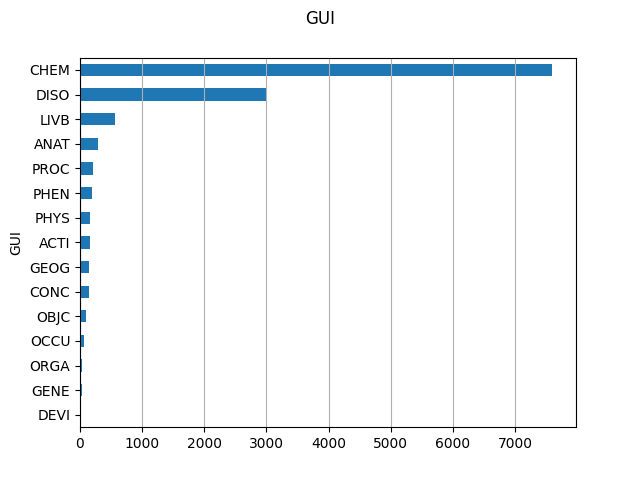

In [5]:
# Plotting the univariate distribution of the data
column = config["y_classificaton_column"]

fig, ax = plt.subplots()
fig.suptitle(column, fontsize=12)
data[column].reset_index().groupby(column).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The graph shows that there are differences of distributions between the GUIs

In [3]:
data = preprocess(config)

Preprocessing data...
Preprocessing done in 10.865649700164795 seconds
Saving preprocessed data...
Saving done in 0.3751261234283447 seconds


In [20]:
def save_the_most_frequent_words(data, column):
    class_col = config["y_classificaton_column"]
    # Get only "Clean_Corpus" which has in "y_classificaton_column" the value of column var
    pd = data[data[class_col] == column]
    wordcloud = WordCloud(background_color='white', max_words = 5).generate(pd['Clean_Corpus'].str.cat(sep=' '))
    wordcloud.to_file('artefact/wordcloud-' + column + '.png')
    
def generate_all_wordclouds(data, config):
    # Save the most frequent words for each different column
    column = config["y_classificaton_column"]
    labels = data[column].unique()
    for label in labels:
        save_the_most_frequent_words(data, label)


In [4]:
# Split dataset 70/30
df_train, df_test = train_test_split(data, test_size=0.3)

# Get values
column = config["y_classificaton_column"]
y_train = df_train[column].values
y_test = df_test[column].values
print(data[config["y_classificaton_column"]].nunique())

15


Seting up X_train_attributes and X_test_attributes with **Nb_Parents**, **Nb_Children**, **Nb_Parents_Children_Known** and **Has_Definition** as features

In [5]:
X_train_attributes = df_train.loc[:,['Has_Definition']].values
X_test_attributes = df_test.loc[:,['Has_Definition']].values

Let's tokenize the corpus and train a word2vec model with the training set.

In [11]:
corpus = df_train["Clean_Corpus"].values

# Create list of lists of Unigrams (eg. ['I', 'am', 'a', 'student', '.'])
def create_list_unigrams(corpus):
    lst_corpus = []
    for string in corpus:
       lst_words = string.split()
       lst_grams = [" ".join(lst_words[i:i+1]) 
                   for i in range(0, len(lst_words), 1)]
       if len(lst_grams) == 0:
          lst_grams = [""]
       lst_corpus.append(lst_grams)
    return lst_corpus

lst_corpus = create_list_unigrams(corpus)

# Detect Bigrams (eg. ['I am', 'a student', '.'])
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
# Detect Trigrams (eg. ['I am a', 'student.'])
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ", min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

## Fit Word2Vec
nlp = gensim.models.word2vec.Word2Vec(lst_corpus,
   vector_size=config["vector_size"], window=config["window"], min_count=1, sg=1, epochs=config["w2v_epochs"])
print("The model has been trained on {} words.\n".format(nlp.corpus_total_words))
print("Shape of the word2vec model: ", nlp.wv.vectors.shape)
print("It means that there are {} words in the model.".format(nlp.wv.vectors.shape[0]))
print("And each word has {} dimensions' vector.\n".format(nlp.wv.vectors.shape[1]))

word = "amine"
try:
   print("The most similar words to '{}' are:".format(word), nlp.wv.most_similar(word))
except KeyError:
   print("The word '{}' is not in the vocabulary".format(word))

The model has been trained on 62243 words.

Shape of the word2vec model:  (5928, 900)
It means that there are 5928 words in the model.
And each word has 900 dimensions' vector.

The most similar words to 'amine' are: [('2-Hydroxyphenethylamine', 0.6613843441009521), ('mutagenicity', 0.6501290202140808), ('carcinogenicity', 0.6394997239112854), ('nucleobase', 0.628211259841919), ('Alkalies', 0.6275863647460938), ('lithium', 0.6260200142860413), ('pressurereducing', 0.6247828602790833), ('vasoconstricting', 0.6234171390533447), ('cesium', 0.6202197670936584), ('carbonate', 0.6191186904907227)]


### Even if there are 300 dimensions, we can try to reduce it to 3 thanks to PCA. This will allow us to visualize the words in 3D.

/home/juan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/juan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


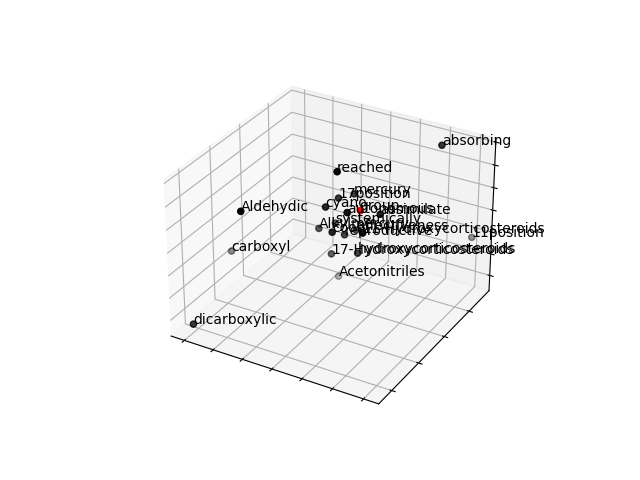

In [12]:
word = "group"

try:
    # Word Embedding
    tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=20)]
    X = nlp.wv[tot_words]

    # PCA to reduce dimensionality from 300 to 3
    pca = manifold.TSNE(perplexity=40, n_components=3, init="pca")
    X = pca.fit_transform(X)

    # Create dtf
    df = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    df["input"] = 0
    df.at["group","input"]=1

    # Plot 3d
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df[df["input"]==0]["x"], 
               df[df["input"]==0]["y"], 
               df[df["input"]==0]["z"], c="black")
    ax.scatter(df[df["input"]==1]["x"], 
               df[df["input"]==1]["y"], 
               df[df["input"]==1]["z"], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
           yticklabels=[], zticklabels=[])
    for label, row in df[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)
    plt.show()
except Exception as e:
    print("Error: " + str(e))


### To include the corpus as features in a Neural Network, we need to:

1- Transform the corpus into padded sequences of words

2- Create Embedding matrix with as index the id's word and as value it vector

3- Set Embedding layer in the Neural Network so that weights every word

<AxesSubplot:>

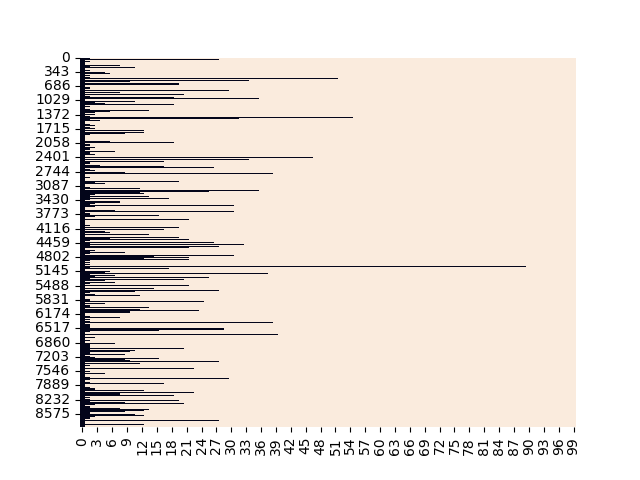

In [13]:
# Tokenize text -> Indexation of each word (eg. {'NaN': 1, 'enzyme': 2, 'amine': 3...})
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN",
                                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

# Create sequence -> Use index of each word from 'tokenizer' to create sentences (eg. ['amine', 'enzyme'] -> [3, 2])
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence. Each sequence are composed of id or 0 to complete the size of 50
# (eg. [3, 2] -> [3, 2, 0, 0, 0, 0, ..., 0])
X_train_word_embedding = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=config["sequence_length"], padding="post", truncating="post")

# Find the length of the largest definition in the vocabulary
largest = data.loc[:,"Clean_Definition"].str.len().sort_values(ascending=False).head(1)
id_largest = largest.keys()[0]
length_largest = len(data.loc[id_largest,"Clean_Definition"].split(' '))
print("Highest length of definitions: ", length_largest)

# Visualization of the shapes of corpus
fig, ax = plt.subplots()
sns.heatmap(X_train_word_embedding==0, vmin=0, vmax=1, cbar=False)

Let's do the same for the test part.
Why did we separe the train and test data set ?

To be sure the bigrams, trigrams and tokenizer are trained only with the training set and keep the test set unknown of any model.

<AxesSubplot:>

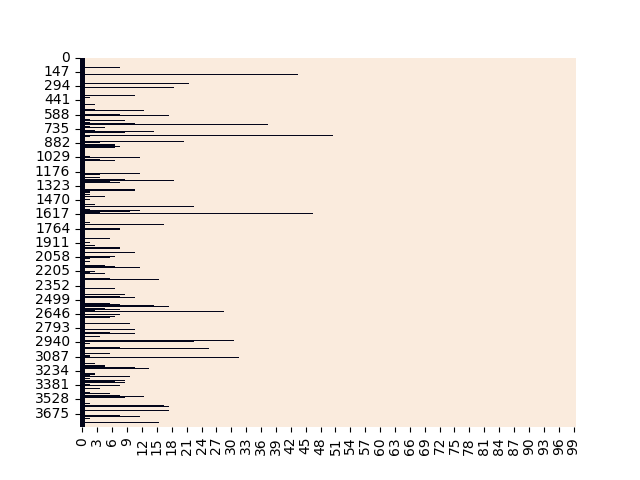

In [14]:
corpus = df_test["Clean_Definition"]

# Create list of lists of Unigrams (eg. ['I', 'am', 'a', 'student', '.'])
lst_corpus = create_list_unigrams(corpus)
    
# Detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

# Text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence. Each sequence are composed of id or 0 to complete the size of 50
X_test_word_embedding = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=config["sequence_length"], padding="post", truncating="post")

# Visualization of the shapes of corpus
fig, ax = plt.subplots()
sns.heatmap(X_test_word_embedding==0, vmin=0, vmax=1, cbar=False)

Let's create our Matrix of embedding following this schema

**Embedding Matrix Explanation**:
![Embedding Matrix Explanation](https://miro.medium.com/max/700/1*KvBp0xzRThA7qTXACT4A-g.png)

In [15]:
# Start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, config["vector_size"]))
for word,idx in dic_vocabulary.items():
    # Update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    # If word not in model then skip and the row stays all 0s
    except:
        pass
    
word = "action"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 29 |idx
embeddings[idx]: (900,) |vector


The Neural Network v1 is built following the [Mauro Di Pietro medium](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794#e0c6)

2022-04-26 09:54:18.417403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-26 09:54:18.417447: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-26 09:54:18.417471: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mistea-abricotier): /proc/driver/nvidia/version does not exist
2022-04-26 09:54:18.422575: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


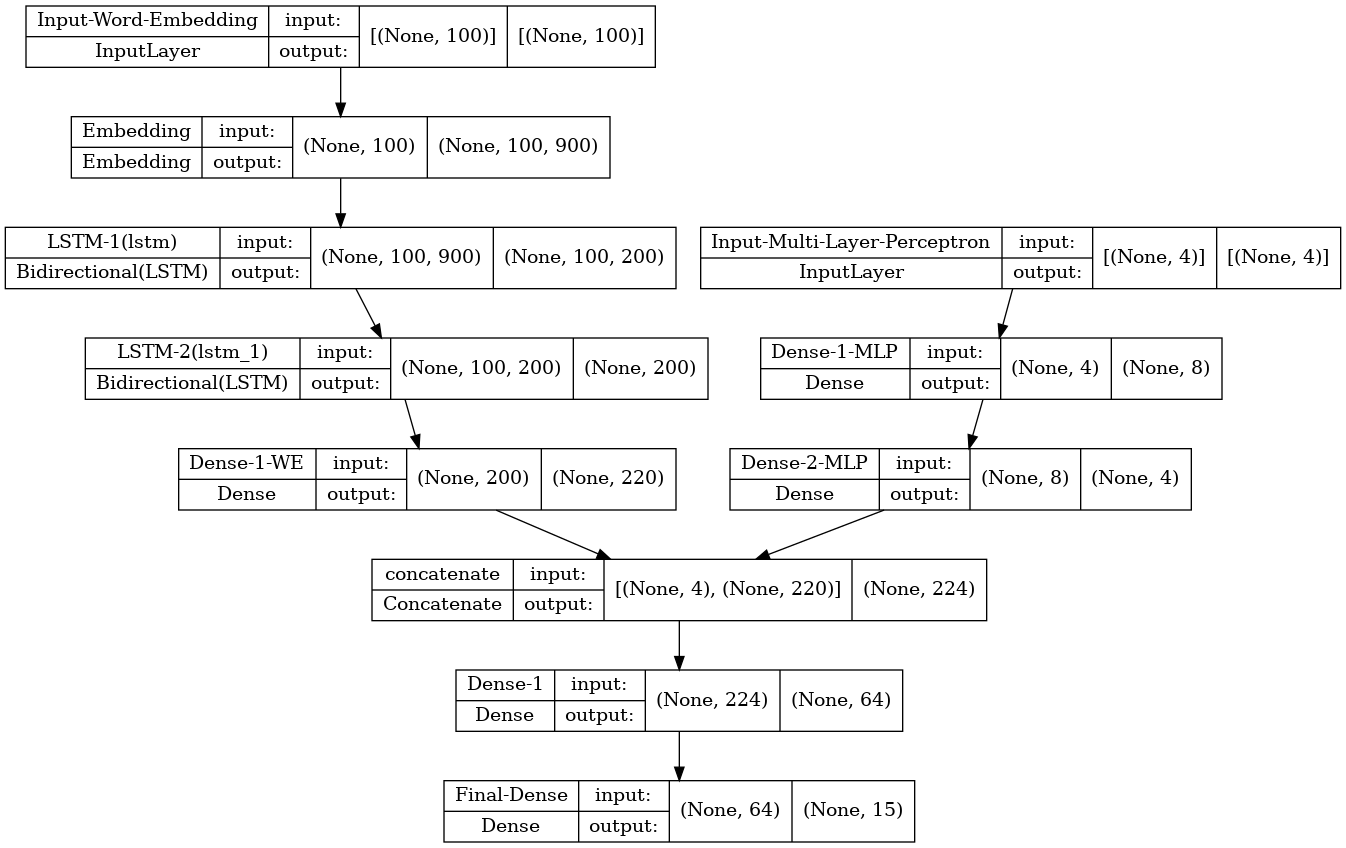

In [16]:
def get_input_layer_and_next_steps(type_model):
    steps = config["neural_network"][type_model]["steps"].copy()
    # Search for the first step with the type "Input"
    first_step = next(step for step in steps if step["type"] == "Input")
    inputs = layers.Input(shape=first_step["input_shape"], name=first_step["name"])
    # Remove first step from the list
    steps.remove(first_step)
    return inputs, steps

def create_model(type_model, inputs=None):
    inputs, steps = get_input_layer_and_next_steps(type_model)

    x = inputs
    for i in steps:
        if i["type"] == "Embedding":
            x = layers.Embedding(input_dim=embeddings.shape[0],
                                 output_dim=embeddings.shape[1],
                                 weights=[embeddings],
                                 trainable=i["trainable"],
                                 name=i["name"])(x)
        elif i["type"] == "LSTM":
            x = layers.Bidirectional(layers.LSTM(
                units=i["units"], return_sequences=i["return_sequences"],
                dropout=i["dropout"]), name=i["name"])(x)
        elif i["type"] == "Dense":
            x = layers.Dense(units=i["units"], activation=i["activation"],
                             name=i["name"])(x)
    
    model = models.Model(inputs, x)
    return model

def create_word_embedding():
    return create_model("word_embedding")

def create_multi_layer_perception():
    return create_model("multi_layer_perception")

def concatenate_neural_network(word_embedding, mlp):
    x = layers.concatenate([mlp.output, word_embedding.output])
    
    steps = config["neural_network"]["concatenate"]["steps"].copy()
    for i in steps:
        if i["type"] == "Dense":
            x = layers.Dense(units=i["units"], activation=i["activation"],
                                         name=i["name"])(x)
            
    # Final layer
    final_activation = config["neural_network"]["out"]["activation"]
    name = config["neural_network"]["out"]["name"]
    y_out = layers.Dense(units=data[config["y_classificaton_column"]].nunique(), activation=final_activation, name=name)(x)
    
    return y_out
    

word_embedding = create_word_embedding()
mlp = create_multi_layer_perception()
y_out = concatenate_neural_network(word_embedding, mlp)
    
optimize = config["neural_network"]["optimizer"]
metrics = config["neural_network"]["metrics"]
loss = config["neural_network"]["loss"]
model_mixed_data = models.Model(inputs=[word_embedding.input, mlp.input], outputs=y_out)
model_mixed_data.compile(loss=loss, optimizer=optimize["name"], metrics=metrics)

plot_model(model_mixed_data, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Let's train the model

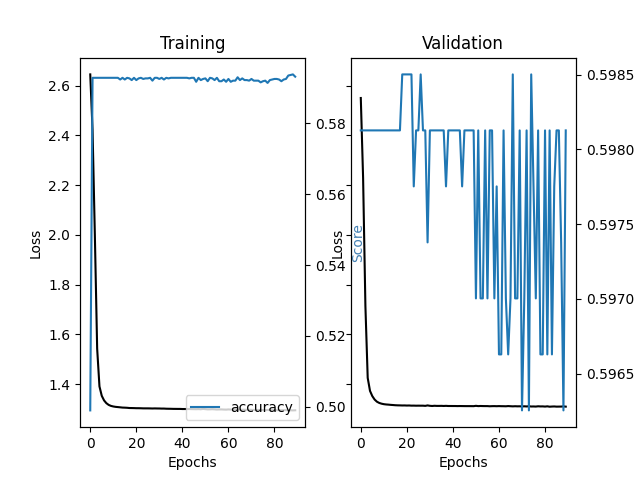

In [17]:
# Encode y_train
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

# Train
epochs = config["neural_network"]["epochs"]
batch_size = config["neural_network"]["batch_size"]
shuffle = config["neural_network"]["shuffle"]
verbose = config["neural_network"]["verbose"]
training = model_mixed_data.fit(x=[X_train_word_embedding, X_train_attributes], y=y_train, batch_size=batch_size, 
                     epochs=epochs, shuffle=shuffle, verbose=verbose, 
                     validation_split=config["test_size"])

# Plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Now we need to test the model with the **test set** !

In [18]:
# Test
# predicted_prob = model.predict(X_test)
predicted_prob = model_mixed_data.predict([X_test_word_embedding, X_test_attributes])
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
print(predicted)


['CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM',

Visualization of the results:

Accuracy: 0.61
Detail:
              precision    recall  f1-score   support

        ACTI       0.00      0.00      0.00        40
        ANAT       0.00      0.00      0.00        88
        CHEM       0.61      1.00      0.75      2310
        CONC       0.00      0.00      0.00        49
        DEVI       0.00      0.00      0.00         8
        DISO       0.00      0.00      0.00       900
        GENE       0.00      0.00      0.00        11
        GEOG       0.00      0.00      0.00        35
        LIVB       0.47      0.05      0.09       159
        OBJC       0.00      0.00      0.00        27
        OCCU       0.00      0.00      0.00        16
        ORGA       0.00      0.00      0.00         9
        PHEN       0.00      0.00      0.00        47
        PHYS       0.00      0.00      0.00        44
        PROC       0.00      0.00      0.00        72

    accuracy                           0.61      3815
   macro avg       0.07      0.07      0.06      3815
wei

/home/juan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


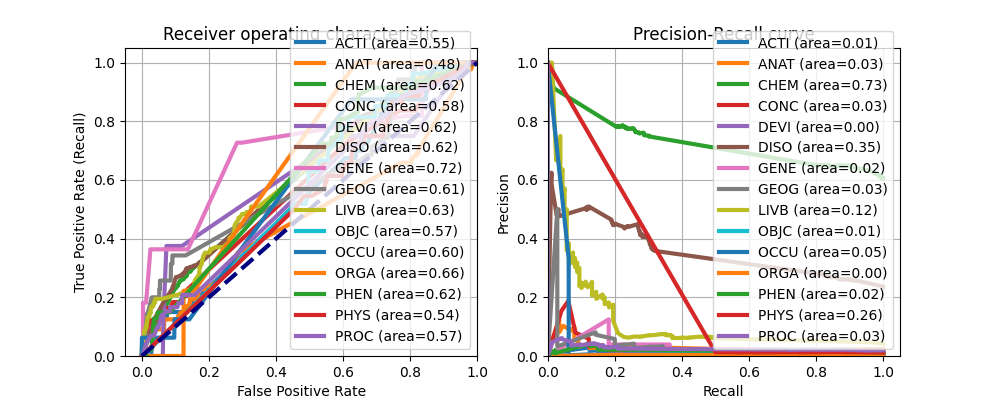

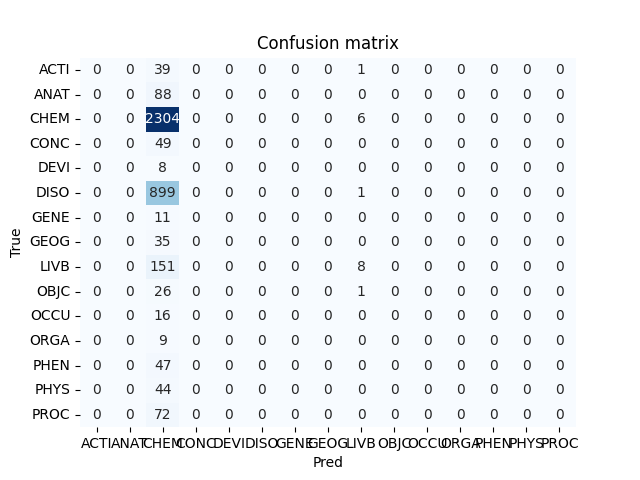

In [19]:
def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = sk_metrics.accuracy_score(y_test, predicted)
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(sk_metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = sk_metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = sk_metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], sk_metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = sk_metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], sk_metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(10,4))